# UFGsim2024infufg
> Module to handle loading, preprocessing and postprocessing of the data from the simulated world for UFG's dataset
>
> Still needs proper documentation

In [1]:
#| default_exp UFGsim2024infufg

In [2]:
#| exports
import torch
import re
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import yaml
from pathlib import Path
import numpy as np
from lightning import LightningDataModule
from torchvision.transforms import v2
from colorcloud.behley2019iccv import SphericalProjection

introduction here

In [3]:
#| exports
class UFGSimDataset(Dataset):
    "Load the UFGSim dataset ina pytorch Dataset object."
    def __init__(self, data_path, is_train=True, transform=None):
        data_path = Path(data_path)
        yaml_path = data_path/'ufg-sim.yaml'
        self.ufgsim_velodyne_path = data_path/'laser_scans'

        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)

        self.labels_dict = metadata['labels']

        ufgsim_velodyne_fns = []

        ufgsim_velodyne_fns += list(self.ufgsim_velodyne_path.rglob('*laser[0-9]/*.bin'))
  
        self.frame_ids = [fn.stem for fn in sorted(ufgsim_velodyne_fns)]
        self.frame_lasers = [fn.parts[-2] for fn in ufgsim_velodyne_fns]

        self.color_map_bgr = metadata['color_map']
        max_key = sorted(self.color_map_bgr.keys())[-1]
        self.color_map_rgb_np = np.zeros((max_key+1,3))
        for k,v in self.color_map_bgr.items():
            self.color_map_rgb_np[k] = np.array(v[::-1], np.float32)
        
        self.transform = transform

    def __len__(self):
        return len(self.frame_ids)

    def set_transform(self, transform):
        self.transform = transform
        
    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        frame_laser = self.frame_lasers[idx]

        frame_path = self.ufgsim_velodyne_path/frame_laser/(frame_id + '.bin')

        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
            x_frame = frame[:, 0]
            y_frame = frame[:, 1]
            z_frame = frame[:, 2]
            label = frame[:, 3].astype(np.uint8)

        mask = label != 0

        if self.transform:
            frame, label, mask = self.transform(frame, label, mask)
        # return x_frame, y_frame, z_frame, label
        return frame, label, mask
        


instructions of download and label description

In [4]:
#| eval: false
data_path = '/workspace/data'
ds = UFGSimDataset(data_path)
ds[250]

(array([[-1.2572704e+01, -3.3362801e-05, -1.5437317e+00,  4.0000000e+00],
        [-1.6822290e+01, -4.4639455e-05, -1.4717574e+00,  4.0000000e+00],
        [-1.9663694e+01, -5.2179381e-05, -1.0305290e+00,  6.0000000e+01],
        ...,
        [-6.2977333e+01,  1.6711601e-04,  1.0992719e+00,  4.0000000e+01],
        [-6.2945255e+01,  1.6703088e-04,  3.2988162e+00,  4.0000000e+01],
        [-6.2909000e+01,  1.6693468e-04,  5.5038161e+00,  4.0000000e+01]],
       dtype=float32),
 array([ 4,  4, 60, ..., 40, 40, 40], dtype=uint8),
 array([ True,  True,  True, ...,  True,  True,  True]))

In [5]:
#| eval: false
frame, label, mask = ds[250]
frame[:,0] - frame[:,2]

array([-11.028973, -15.350533, -18.633165, ..., -64.07661 , -66.24407 ,
       -68.41282 ], dtype=float32)

In [6]:
#| exports
class ProjectionSimTransform(nn.Module):
    def __init__(self, projection):
        super().__init__()
        self.projection = projection
        self.W = projection.W
        self.H = projection.H

    def forward(self, frame, label, mask):
        scan_xyz = frame[:,:3]
        

        depth = np.linalg.norm(scan_xyz, 2, axis=1)

        proj_x, proj_y, outliers = self.projection.get_xy_projections(scan_xyz, depth)

        order = np.argsort(depth)[::-1]
        info_list = [scan_xyz, depth[..., np.newaxis]]
        if label is not None:
            info_list += [mask[..., np.newaxis]]
            info_list += [label[..., np.newaxis]]

        scan_info = np.concatenate(info_list, axis=-1)
        scan_info = scan_info[order]
        proj_y = proj_y[order]
        proj_x = proj_x[order]


        projections_img = np.zeros((self.H, self.W, 2+len(info_list)))
        projections_img[:,:,-1] -= 1
        projections_img[proj_y, proj_x] = scan_info

        if label is not None:
            frame_img = projections_img[:,:,:-2]
            label_img = projections_img[:,:,-1].astype(int)
            mask_img = projections_img[:,:,-2].astype(bool)
            mask_img = mask_img & (label_img > -1)

        else:
            frame_img = projections_img
            label_img = None
            mask_img = projections_img[:,:,-1] >= 0

        return frame_img, label_img, mask_img

In [7]:
#| eval: false
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=1024, H=64)
tfms = ProjectionSimTransform(proj)
ds.set_transform(tfms)
frame_img, label_img, mask_img = ds[250]

In [8]:
#| eval: false
frame_img[:2], frame_img.shape, frame_img.dtype

(array([[[-6.29295311e+01, -1.66989164e-04,  3.29799199e+00,
           6.30158920e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [-5.88426628e+01, -8.42398286e-01,  3.08412480e+00,
           5.89294548e+01],
         ...,
         [-6.76497955e+01,  9.68482196e-01,  3.54573345e+00,
           6.77495728e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [-6.29452553e+01,  1.67030885e-04,  3.29881620e+00,
           6.30316391e+01]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000

In [9]:
#| eval: false
label_img[:2], label_img.shape, label_img.dtype, set(label_img.flatten())

(array([[40, -1, 40, ..., 40, -1, 40],
        [-1, -1, -1, ..., -1, -1, -1]]),
 (64, 1024),
 dtype('int32'),
 {-1, 0, 4, 7, 9, 12, 20, 40, 42, 55, 60, 65, 80})

In [10]:
#| eval: false
mask_img[:2], mask_img.shape, mask_img.dtype

(array([[ True, False,  True, ...,  True, False,  True],
        [False, False, False, ..., False, False, False]]),
 (64, 1024),
 dtype('bool'))

In [11]:
#| exports
class ProjectionSimVizTransform(nn.Module):
    def __init__(self, color_map_rgb_np):
        super().__init__()
        self.color_map_rgb_np = color_map_rgb_np

    def scale(self, img, min_value, max_value):
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)

    def forward(self, frame_img, label_img, mask_img):
        normalized_frame_img = None
        if frame_img is not None:
            x = self.scale(frame_img[:,:,0], -100., 100.)
            y = self.scale(frame_img[:,:,1], -100., 100.)
            z = self.scale(frame_img[:,:,2], -31., 5.)
            d = self.scale(frame_img[:,:,3], 0., 100.)
            normalized_frame_img = np.stack((x, y, z, d), axis=-1)
            normalized_frame_img[mask_img == False] *= 0

        colored_label_img = None
        if label_img is not None:
            colored_label_img = np.zeros(label_img.shape + (3,))
            colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
            colored_label_img = colored_label_img.astype(int)

        return normalized_frame_img, colored_label_img, mask_img

In [12]:
#| eval: false
from matplotlib import pyplot as plt

In [13]:
#| eval: false
def plot_projections(img, label):
    fig, axs = plt.subplots(5, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'd', 'label'])):
        if i < 4:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

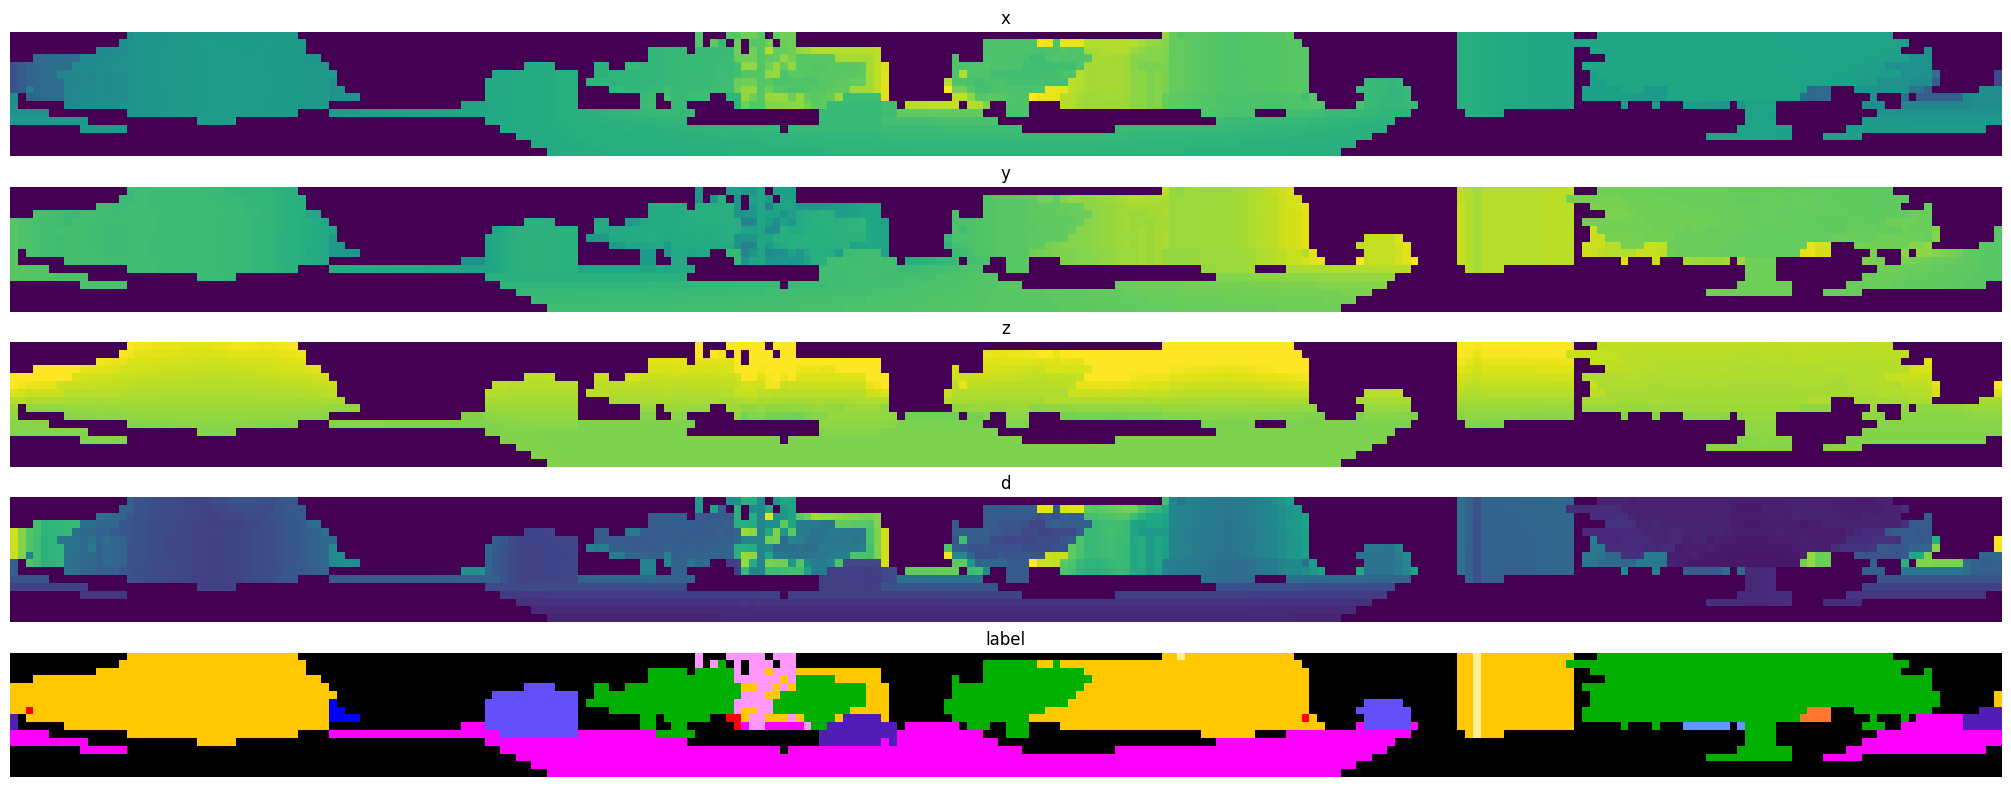

In [14]:
#| eval: false
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=256, H=16) 
tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionSimVizTransform(ds.color_map_rgb_np),
])
ds.set_transform(tfms)
img, label, _ = ds[250]

plot_projections(img, label)

In [15]:
#| eval: false
%timeit img, label, _ = ds[0]

1.47 ms ± 55.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()